In [1551]:
import numpy as np
import pandas as pd
from pandas.api.types import is_object_dtype
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from xgboost import XGBRegressor
import matplotlib.gridspec as gridspec
import matplotlib.pylab as pl

In [1552]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.options.display.float_format = '{:.2f}'.format

In [1553]:
train=pd.read_csv('/home/ivan_pronin/IT/kaggle/house-prices-advanced-regression-techniques/train.csv')
test=pd.read_csv('/home/ivan_pronin/IT/kaggle/house-prices-advanced-regression-techniques/test.csv')
sample_submission=pd.read_csv('/home/ivan_pronin/IT/kaggle/house-prices-advanced-regression-techniques/sample_submission.csv')

In [1554]:
def choice(row):
    if row['YearRemodAdd'] == row['YearBuilt']:
        return row['YearRemodAdd']
    else:
        return row['YearBuilt']

train['BuildorRemod']=train.apply(choice, axis=1)
train.drop(columns=['YearRemodAdd','YearBuilt'], inplace=True)

In [1555]:
train=train.drop(columns=['Alley', 'PoolQC','Fence', 'MiscFeature','GarageArea', 'MSSubClass'])
test=test.drop(columns=['Alley', 'PoolQC','Fence', 'MiscFeature','GarageArea', 'MSSubClass'])
# y=train['SalePrice'].to_numpy()
# train.drop(columns=['SalePrice'], inplace=True)

In [1556]:
print(train.shape)
print(test.shape)

(1460, 74)
(1459, 74)


In [1557]:
nonnumeric_features=[]
for col in train.columns:
    if is_object_dtype(train[col]):
        nonnumeric_features.append(col)

In [1558]:
train[nonnumeric_features].describe()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,588,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,1460,1460
unique,5,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,3,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,9,6
top,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,WD,Normal
freq,1151,1454,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,445,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,1267,1198


In [1559]:
train.loc[:, ~train.columns.isin(nonnumeric_features)].describe()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,BuildorRemod
count,1460.00,1201.00,1460.00,1460.00,1460.00,1452.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1379.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00
mean,730.50,70.05,10516.83,6.10,5.58,103.69,443.64,46.55,567.24,1057.43,1162.63,346.99,5.84,1515.46,0.43,0.06,1.57,0.38,2.87,1.05,6.52,0.61,1978.51,1.77,94.24,46.66,21.95,3.41,15.06,2.76,43.49,6.32,2007.82,180921.20,1971.27
std,421.61,24.28,9981.26,1.38,1.11,181.07,456.10,161.32,441.87,438.71,386.59,436.53,48.62,525.48,0.52,0.24,0.55,0.50,0.82,0.22,1.63,0.64,24.69,0.75,125.34,66.26,61.12,29.32,55.76,40.18,496.12,2.70,1.33,79442.50,30.20
min,1.00,21.00,1300.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,334.00,0.00,0.00,334.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,1900.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2006.00,34900.00,1872.00
25%,365.75,59.00,7553.50,5.00,5.00,0.00,0.00,0.00,223.00,795.75,882.00,0.00,0.00,1129.50,0.00,0.00,1.00,0.00,2.00,1.00,5.00,0.00,1961.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,2007.00,129975.00,1954.00
50%,730.50,69.00,9478.50,6.00,5.00,0.00,383.50,0.00,477.50,991.50,1087.00,0.00,0.00,1464.00,0.00,0.00,2.00,0.00,3.00,1.00,6.00,1.00,1980.00,2.00,0.00,25.00,0.00,0.00,0.00,0.00,0.00,6.00,2008.00,163000.00,1973.00
75%,1095.25,80.00,11601.50,7.00,6.00,166.00,712.25,0.00,808.00,1298.25,1391.25,728.00,0.00,1776.75,1.00,0.00,2.00,1.00,3.00,1.00,7.00,1.00,2002.00,2.00,168.00,68.00,0.00,0.00,0.00,0.00,0.00,8.00,2009.00,214000.00,2000.00
max,1460.00,313.00,215245.00,10.00,9.00,1600.00,5644.00,1474.00,2336.00,6110.00,4692.00,2065.00,572.00,5642.00,3.00,2.00,3.00,2.00,8.00,3.00,14.00,3.00,2010.00,4.00,857.00,547.00,552.00,508.00,480.00,738.00,15500.00,12.00,2010.00,755000.00,2010.00


In [1560]:
train

,Id,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,BuildorRemod
0,1,RL,65.00,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.00,RFn,2,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500,2003
1,2,RL,80.00,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,Gable,CompShg,MetalSd,MetalSd,NaN,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.00,RFn,2,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500,1976
2,3,RL,68.00,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.00,RFn,2,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500,2001
3,4,RL,60.00,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.00,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.00,Unf,3,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000,1915
4,5,RL,84.00,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.00,RFn,3,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,RL,62.00,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,Gable,CompShg,VinylSd,VinylSd,NaN,0.00,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.00,RFn,2,TA,TA,Y,0,40,0,0,0,0,0,8,2007,WD,Normal,175000,1999
1456,1457,RL,85.00,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,Gable,CompShg,Plywood,Plywood,Stone,119.00,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.00,Unf,2,TA,TA,Y,349,0,0,0,0,0,0,2,2010,WD,Normal,210000,1978
1457,1458,RL,66.00,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,Gable,CompShg,CemntBd,CmentBd,NaN,0.00,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.00,RFn,1,TA,TA,Y,0,60,0,0,0,0,2500,5,2010,WD,Normal,266500,1941
1458,1459,RL,68.00,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,Hip,CompShg,MetalSd,MetalSd,NaN,0.00,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,NaN,Attchd,1950.00,Unf,1,TA,TA,Y,366,0,112,0,0,0,0,4,2010,WD,Normal,142125,1950


In [1561]:
with open('/home/ivan_pronin/IT/kaggle/house-prices-advanced-regression-techniques/data_description.txt', 'r') as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
#         if any(feature in line for feature in ['LotFrontage', 'MasVnrType', 'FireplaceQu']):
        if 'HalfBath' in line:
            print(line)
            for j in range(i+1, min(i+10, len(lines))):
                print(lines[j])

BsmtHalfBath: Basement half bathrooms



FullBath: Full bathrooms above grade



HalfBath: Half baths above grade



Bedroom: Bedrooms above grade (does NOT include basement bedrooms)



Kitchen: Kitchens above grade



HalfBath: Half baths above grade



Bedroom: Bedrooms above grade (does NOT include basement bedrooms)



Kitchen: Kitchens above grade



KitchenQual: Kitchen quality



       Ex	Excellent

       Gd	Good



In [1562]:
nonnumeric_features.extend(['Id',
                            'BsmtFullBath',
                            ])

In [1563]:
zero_data_set_sum_train=train.isnull().sum()
zero_data_set_percentage_train=train.isnull().sum()/train.shape[0]*100
zero_data_set_train=pd.DataFrame({'sum':zero_data_set_sum_train, 'percentage': zero_data_set_percentage_train})
zero=zero_data_set_train.loc[zero_data_set_train['sum']>0]

In [1564]:
zero

,sum,percentage
LotFrontage,259,17.74
MasVnrType,872,59.73
MasVnrArea,8,0.55
BsmtQual,37,2.53
BsmtCond,37,2.53
BsmtExposure,38,2.60
BsmtFinType1,37,2.53
BsmtFinType2,38,2.60
Electrical,1,0.07
FireplaceQu,690,47.26


In [1565]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='constant', fill_value=-999)
column_to_impute_train=[]
for i in range(len(zero.index)):
    column_to_impute_train.append(zero.index[i])
for col in column_to_impute_train:
    imputed_column = imputer.fit_transform(train[[col]])
    train[[col]] = imputed_column

In [1566]:
zero_data_set_sum_test=test.isnull().sum()
zero_data_set_percentage_test=test.isnull().sum()/test.shape[0]*100
zero_data_set_test=pd.DataFrame({'sum':zero_data_set_sum_test, 'percentage': zero_data_set_percentage_test})
zero2=zero_data_set_test.loc[zero_data_set_test['sum']>0]
zero2

,sum,percentage
MSZoning,4,0.27
LotFrontage,227,15.56
Utilities,2,0.14
Exterior1st,1,0.07
Exterior2nd,1,0.07
MasVnrType,894,61.27
MasVnrArea,15,1.03
BsmtQual,44,3.02
BsmtCond,45,3.08
BsmtExposure,44,3.02


In [1567]:
column_to_impute_test=[]
for i in range(len(zero2.index)):
    column_to_impute_test.append(zero2.index[i])
for col in column_to_impute_test:
    imputed_column = imputer.fit_transform(test[[col]])
    test[[col]] = imputed_column

In [1568]:
test['BsmtFullBath']=test['BsmtFullBath'].astype(int)

In [1569]:
# data_list=['Neighborhood', 'BsmtQual', 'KitchenQual', 'FireplaceQu', 'ExterQual', 'GarageType', 'CentralAir', 'BsmtExposure']
# for col in data_list:
#     train[col]=train[col].astype(str)
# fig,ax=pl.subplots(1,8, figsize=(30,10))
# count=0
# for col in data_list:
#     ax[count].hist(train[col])
#     ax[count].set_xlabel(col)
#     count+=1
# plt.show()

In [1570]:
train[nonnumeric_features]=train[nonnumeric_features].astype('category')
test[nonnumeric_features]=test[nonnumeric_features].astype('category')

In [1571]:
numeric_features=[]
for col in train.columns:
    if is_numeric_dtype(train[col]):
        numeric_features.append(col)
    else:
        pass
print(numeric_features)

['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'BuildorRemod']


array([[<Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>,
        <Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>],
       [<Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>,
        <Axes: title={'center': 'TotalBsmtSF'}>,
        <Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>],
       [<Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtHalfBath'}>,
        <Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>,
        <Axes: title={'center': 'BedroomAbvGr'}>,
        <Axes: title={'center': 'KitchenAbvGr'}>],
       [<Axes: title={'center': 'TotRmsAbvGrd'}>,
        <Axes: title={'center': 'Fireplaces'}>,
        <Axes: title={'center': 'Gar

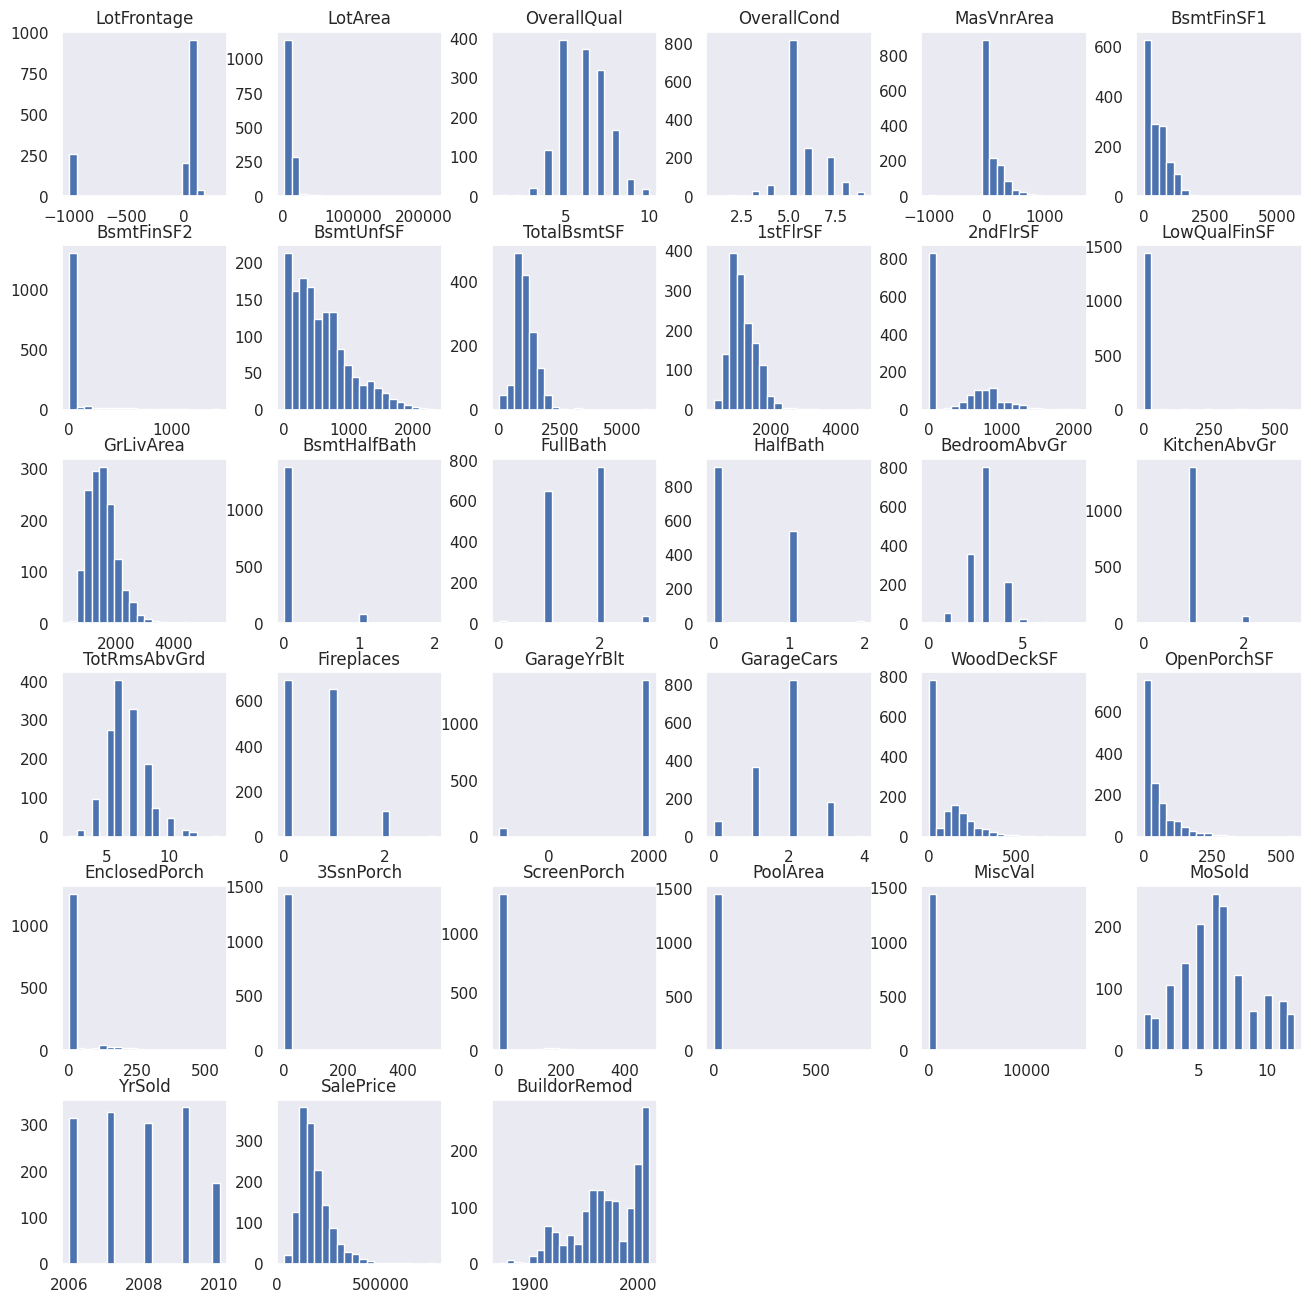

In [1572]:
train.hist(figsize=(16,16), bins=20, grid=False)

In [1573]:
train[numeric_features].columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice', 'BuildorRemod'],
      dtype='object')

In [1574]:
train.loc[train['PoolArea']>0, 'PoolArea']=1
test.loc[test['PoolArea']>0, 'PoolArea']=1

In [1575]:
# for col in numeric_features:
#     print(train[col].value_counts())

In [1576]:
train[numeric_features].columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice', 'BuildorRemod'],
      dtype='object')

In [1577]:
with open('/home/ivan_pronin/IT/kaggle/house-prices-advanced-regression-techniques/data_description.txt', 'r') as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
#         if any(feature in line for feature in ['LotFrontage', 'MasVnrType', 'FireplaceQu']):
        if 'YearBuilt' in line:
            print(line)
            for j in range(i+1, min(i+10, len(lines))):
                print(lines[j])

YearBuilt: Original construction date



YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)



RoofStyle: Type of roof



       Flat	Flat

       Gable	Gable

       Gambrel	Gabrel (Barn)

       Hip	Hip



In [1578]:
train[nonnumeric_features]

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition,Id,BsmtFullBath
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,-999,Attchd,RFn,TA,TA,Y,WD,Normal,1,1
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,-999,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal,2,0
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal,3,1
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,-999,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,WD,Abnorml,4,1
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,-999,TA,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal,1456,0
1456,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,Plywood,Plywood,Stone,TA,TA,CBlock,Gd,TA,No,ALQ,Rec,GasA,TA,Y,SBrkr,TA,Min1,TA,Attchd,Unf,TA,TA,Y,WD,Normal,1457,1
1457,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,CemntBd,CmentBd,-999,Ex,Gd,Stone,TA,Gd,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,WD,Normal,1458,0
1458,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,MetalSd,MetalSd,-999,TA,TA,CBlock,TA,TA,Mn,GLQ,Rec,GasA,Gd,Y,FuseA,Gd,Typ,-999,Attchd,Unf,TA,TA,Y,WD,Normal,1459,1


In [1579]:
# gs = gridspec.GridSpec(7, 6)
# plt.figure(figsize=(50,30))

# column=0
# for i in range(7):
#     column_curr=column
#     for z in range(6):
#         if column_curr <len(numeric_features):
#             ax = plt.subplot(gs[i, z])
#             ax.scatter(train[train[numeric_features].columns[column_curr]], train['SalePrice'],)
#             ax.set_xlabel(train[numeric_features].columns[column_curr])
#             column_curr+=1
#             column=column_curr
# column+=7

# plt.show()

In [1580]:
smoth_columns=[
               'LotArea',
            #   'BsmtFinSF2'
        
               ]

In [1581]:
for col in smoth_columns:
    q1 = np.percentile(train[col], 25)
    q3 = np.percentile(train[col], 75)
    iqr = q3 - q1
    lower_bound = q1 - 2 * iqr
    upper_bound = q3 + 2 * iqr
    train.loc[(train[col] > upper_bound) | (train[col] < lower_bound), col] = np.nan
    train[col].interpolate(method='polynomial', order=5, inplace=True)

In [1582]:
# for col in smoth_columns:
#     q1 = np.percentile(test[col], 25)
#     q3 = np.percentile(test[col], 75)
#     iqr = q3 - q1
#     lower_bound = q1 - 2 * iqr
#     upper_bound = q3 + 2 * iqr
#     test.loc[(test[col] > upper_bound) | (test[col] < lower_bound), col] = np.nan
#     test[col].interpolate(method='polynomial', order=5, inplace=True)

In [1583]:
train[numeric_features].columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice', 'BuildorRemod'],
      dtype='object')

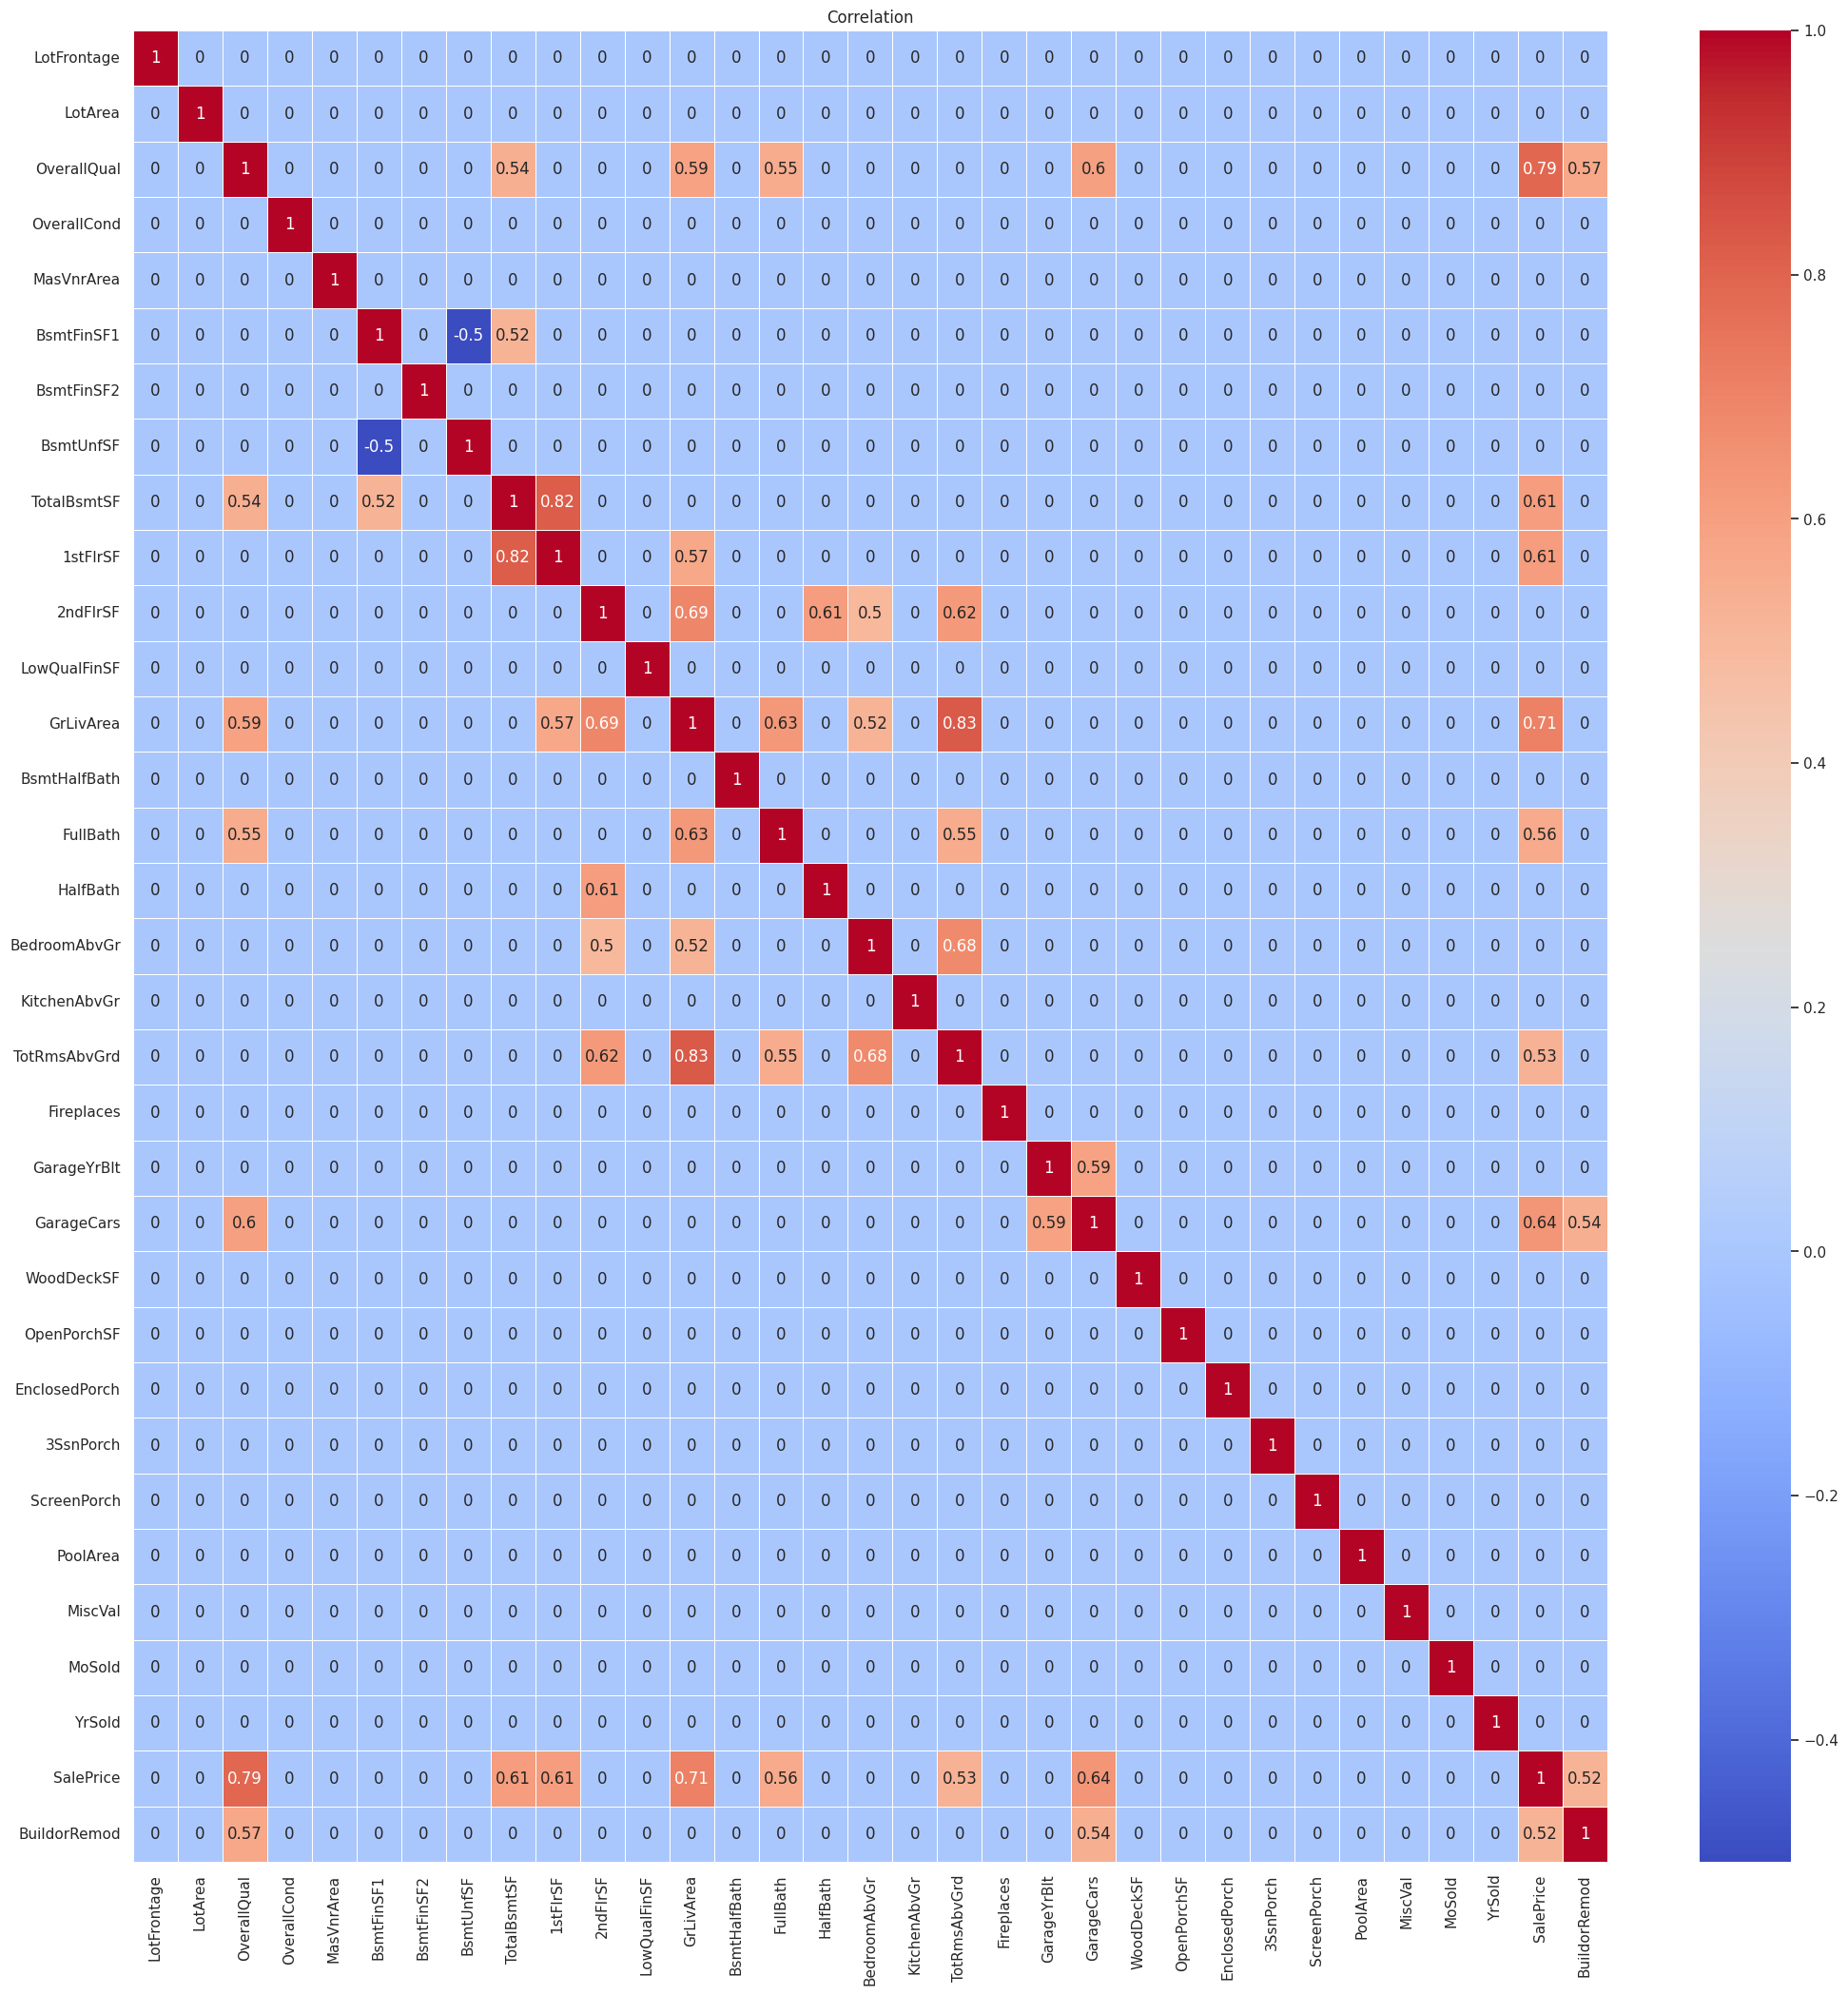

In [1584]:
plt.figure(figsize=(25,25))

sns.set(font_scale=1)

corr_matrix=train[numeric_features].corr()
corr_matrix=np.round(corr_matrix,2)
corr_matrix[np.abs(corr_matrix)<0.5]=0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation')
plt.show()

In [1585]:
y=train['SalePrice'].to_numpy()
train.drop(columns=['SalePrice'], inplace=True)

In [1586]:
numeric_features.remove('SalePrice')

In [1587]:
for col in numeric_features:
    train[col]=train[col].astype(str)
    # test[col]=test[col].astype(str)

In [1588]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train, y, test_size=0.1, random_state=2)

In [1589]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1314, 73), (1314,), (146, 73), (146,))

In [1590]:
import catboost as cb
train_dataset = cb.Pool(x_train,y_train,
                        cat_features=nonnumeric_features
)                                                     
test_dataset = cb.Pool(x_test,y_test,          
                       cat_features=nonnumeric_features)

In [1591]:
from catboost import CatBoostRegressor
CAT=cb.CatBoostRegressor(metric_period=100,
                         eval_metric='RMSE',
                         task_type='GPU',
                         iterations=1500, 
                         learning_rate=0.04,
                         early_stopping_rounds = 50,
                         depth=8
                        )
CAT.fit(train_dataset,
        eval_set=test_dataset
)

0:	learn: 75960.0755697	test: 89044.0628545	best: 89044.0628545 (0)	total: 92.5ms	remaining: 2m 18s
100:	learn: 23810.1764934	test: 28816.8347753	best: 28816.8347753 (100)	total: 9.47s	remaining: 2m 11s
200:	learn: 19437.4885901	test: 25700.8883254	best: 25700.8883254 (200)	total: 17.8s	remaining: 1m 55s
300:	learn: 17595.7889746	test: 24862.7393415	best: 24862.7393415 (300)	total: 26.7s	remaining: 1m 46s
400:	learn: 16659.3116834	test: 24497.5070714	best: 24497.4761507 (399)	total: 37.1s	remaining: 1m 41s
500:	learn: 15959.0444715	test: 24191.9814452	best: 24191.9814452 (500)	total: 47.9s	remaining: 1m 35s
600:	learn: 15367.6457886	test: 24105.8476121	best: 24103.4849478 (558)	total: 57.9s	remaining: 1m 26s
700:	learn: 14923.1115440	test: 23994.7683796	best: 23987.0386919 (690)	total: 1m 7s	remaining: 1m 16s
800:	learn: 14462.7861723	test: 23822.3553716	best: 23809.8193442 (790)	total: 1m 16s	remaining: 1m 6s
900:	learn: 14108.0821380	test: 23663.2073742	best: 23663.2073742 (900)	tota

In [1592]:
feature_importance = CAT.get_feature_importance(train_dataset)
feature_names = train.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

feature_importance_df

,Feature,Importance
42,GrLivArea,23.34
15,OverallQual,17.94
34,TotalBsmtSF,5.90
57,GarageCars,5.57
30,BsmtFinSF1,5.53
39,1stFlrSF,4.67
10,Neighborhood,3.94
26,BsmtQual,3.13
49,KitchenQual,2.89
40,2ndFlrSF,2.83


In [1593]:
# data_for_graph=feature_importance_df.head(20)
# data_for_graph=data_for_graph['Feature'].to_list()

In [1594]:
# data_list=[]
# for i in data_for_graph:
#     if i in nonnumeric_features:
#         data_list.append(i)
# print(data_list)

In [1595]:
# predictions=CAT.predict(test)
# predictions

In [1596]:
# answer=pd.DataFrame(predictions, columns=["SalePrice"])
# answer

In [1597]:
# test=test.join(answer)
# test

In [1598]:
# final=test[['Id', 'SalePrice']]
# final

In [1599]:
# final.to_csv('my_answer7.csv', index=False)